# PROJECT 1 - PART 1

## 0 - imports

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
import shap
import numpy as np

## 1 - Q1 Exploratory Data Analysis

### 1.1 - data distribution

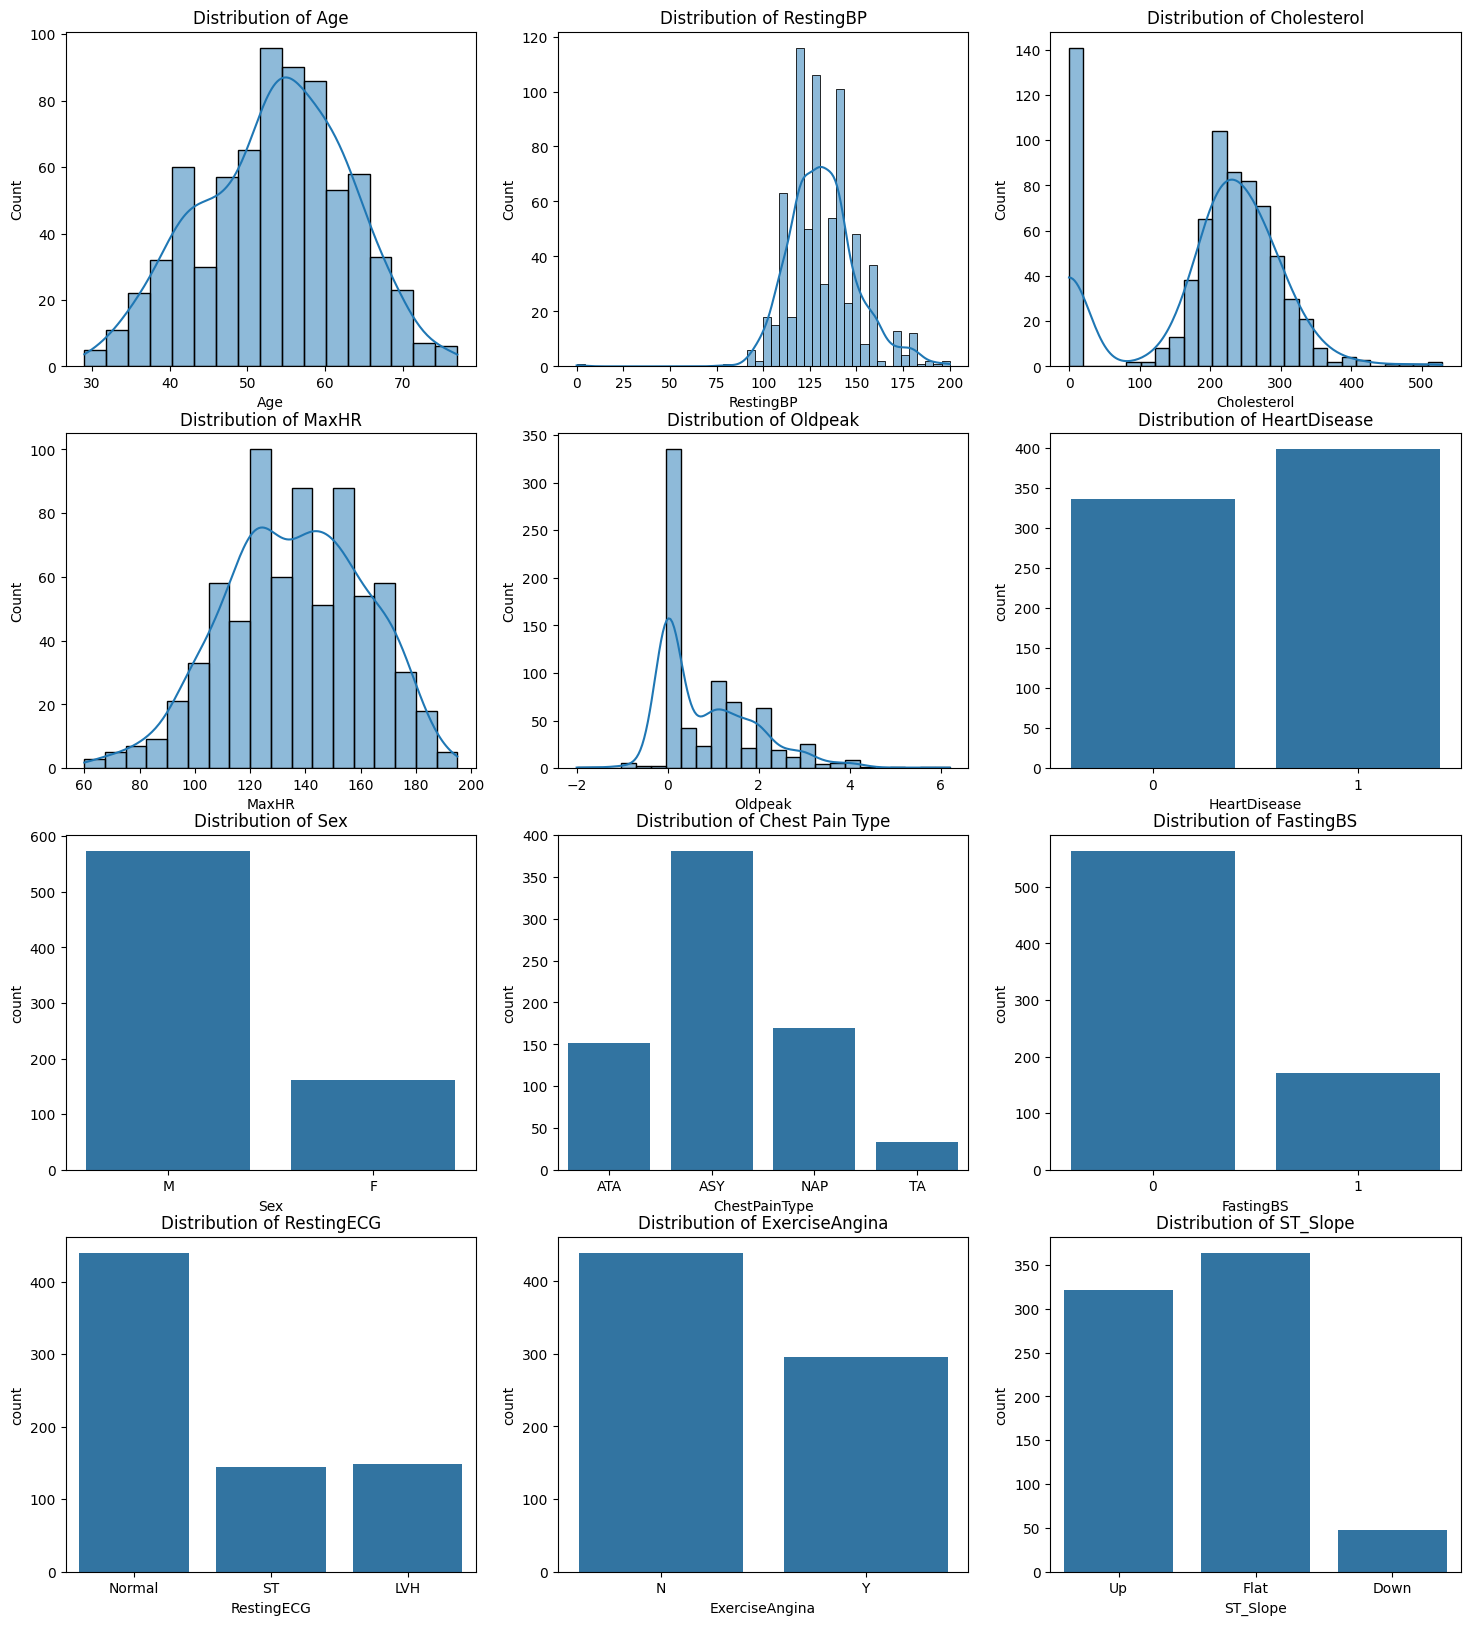

In [346]:
# 0 - load dataset
df = pd.read_csv("datasets/heart_failure/train_val_split.csv")
# 1 - data distributions
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
# categorical features
sb.countplot(data=df, x='Sex', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Sex')
sb.countplot(data=df, x='ChestPainType', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Chest Pain Type')
sb.countplot(data=df, x='FastingBS', ax=axes[2, 2])
axes[2, 2].set_title('Distribution of FastingBS')
sb.countplot(data=df, x='RestingECG', ax=axes[3, 0])
axes[3, 0].set_title('Distribution of RestingECG')
sb.countplot(data=df, x='ExerciseAngina', ax=axes[3, 1])
axes[3, 1].set_title('Distribution of ExerciseAngina')
sb.countplot(data=df, x='ST_Slope', ax=axes[3, 2])
axes[3, 2].set_title('Distribution of ST_Slope')
sb.countplot(data=df, x='HeartDisease', ax=axes[1, 2])
axes[1, 2].set_title('Distribution of HeartDisease')
# numerical features
numerical_features = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak']
for i, feature in enumerate(numerical_features, start=1):
    i = i-1
    sb.histplot(data=df, x=feature, ax=axes[i // 3, i % 3], kde=True)
    axes[i // 3, i % 3].set_title(f'Distribution of {feature}')

#### NOTES AND OBSERVATIONS:
- AGE = age of the subjects, (29,77), peak 55 ca
- SEX = gender of the patient, M/F, mostly males
- CHEST PAIN TYPE = type of chest pain experienced by the patient, (ATA, ASY, NAP, TA), mostly ASY
--------------------------------------------------------------------------
med note: 
- ATA (Typical Angina):type of chest pain typically occurs when the heart is working harder than usual, considered a classic symptom of coronary artery disease (CAD)
- ASY (Atypical Angina): chest pain that doesn't fit the typical pattern of typical angina, still indicate underlying heart problems
- NAP (Non-Anginal Pain): chest discomfort or pain that is not related to angina or heart-related issues, not directly related to coronary artery disease
- TA (Asymptomatic): patient does not experience any chest pain
--------------------------------------------------------------------------
- RESTING BP = resting blood pressure of the patient, (should be under 120), however most of the data is above 120 -> higher RBP = increased risk of CHD, peaks (120,130,140)
- CHOLESTEROL = cholesterol level of the patient, (0,530), high cholesterol is a major risk factor for CHD, IDK ABOUT VALUES
- FASTING BS = amount of glucose in the bloodstream after fasting for at least 8 hours, (0 if <120 mg/dl, 1 if> 120 mg/dl), if 1 -> significant risk factor for CHD
- RESTING ECG = electrical activity of the heart while the patient is at rest, (normal, ST, LVH), ST segment changes = indicate risk of CHD
- MAX HR = maximum heart rate achieved by the patient, (60, 195), abnormal responses may indicate underlying heart disease, IDK ABOUT VALUES
- EXERCISE ANGINA = chest pain that occurs during physical activity, (N,Y), angina is a common symptom of CHD
- OLD PEAK = ST depression induced by exercise relative to rest, (-2, 6.2), ST depression during exercise stress testing is a common finding in patients with CHD, IDK ABOUT VALUES
- ST SLOPE = direction and angle of the ST segment on an electrocardiogram, (Up, Flat, Down), down ST slope is associated with CHD
- HEART DISEASE = blood vessel diameter narrowing, (0 = < 50%, 1 = > 50%), 1 = CHD

### 1.2 - features' relationship with heart disease

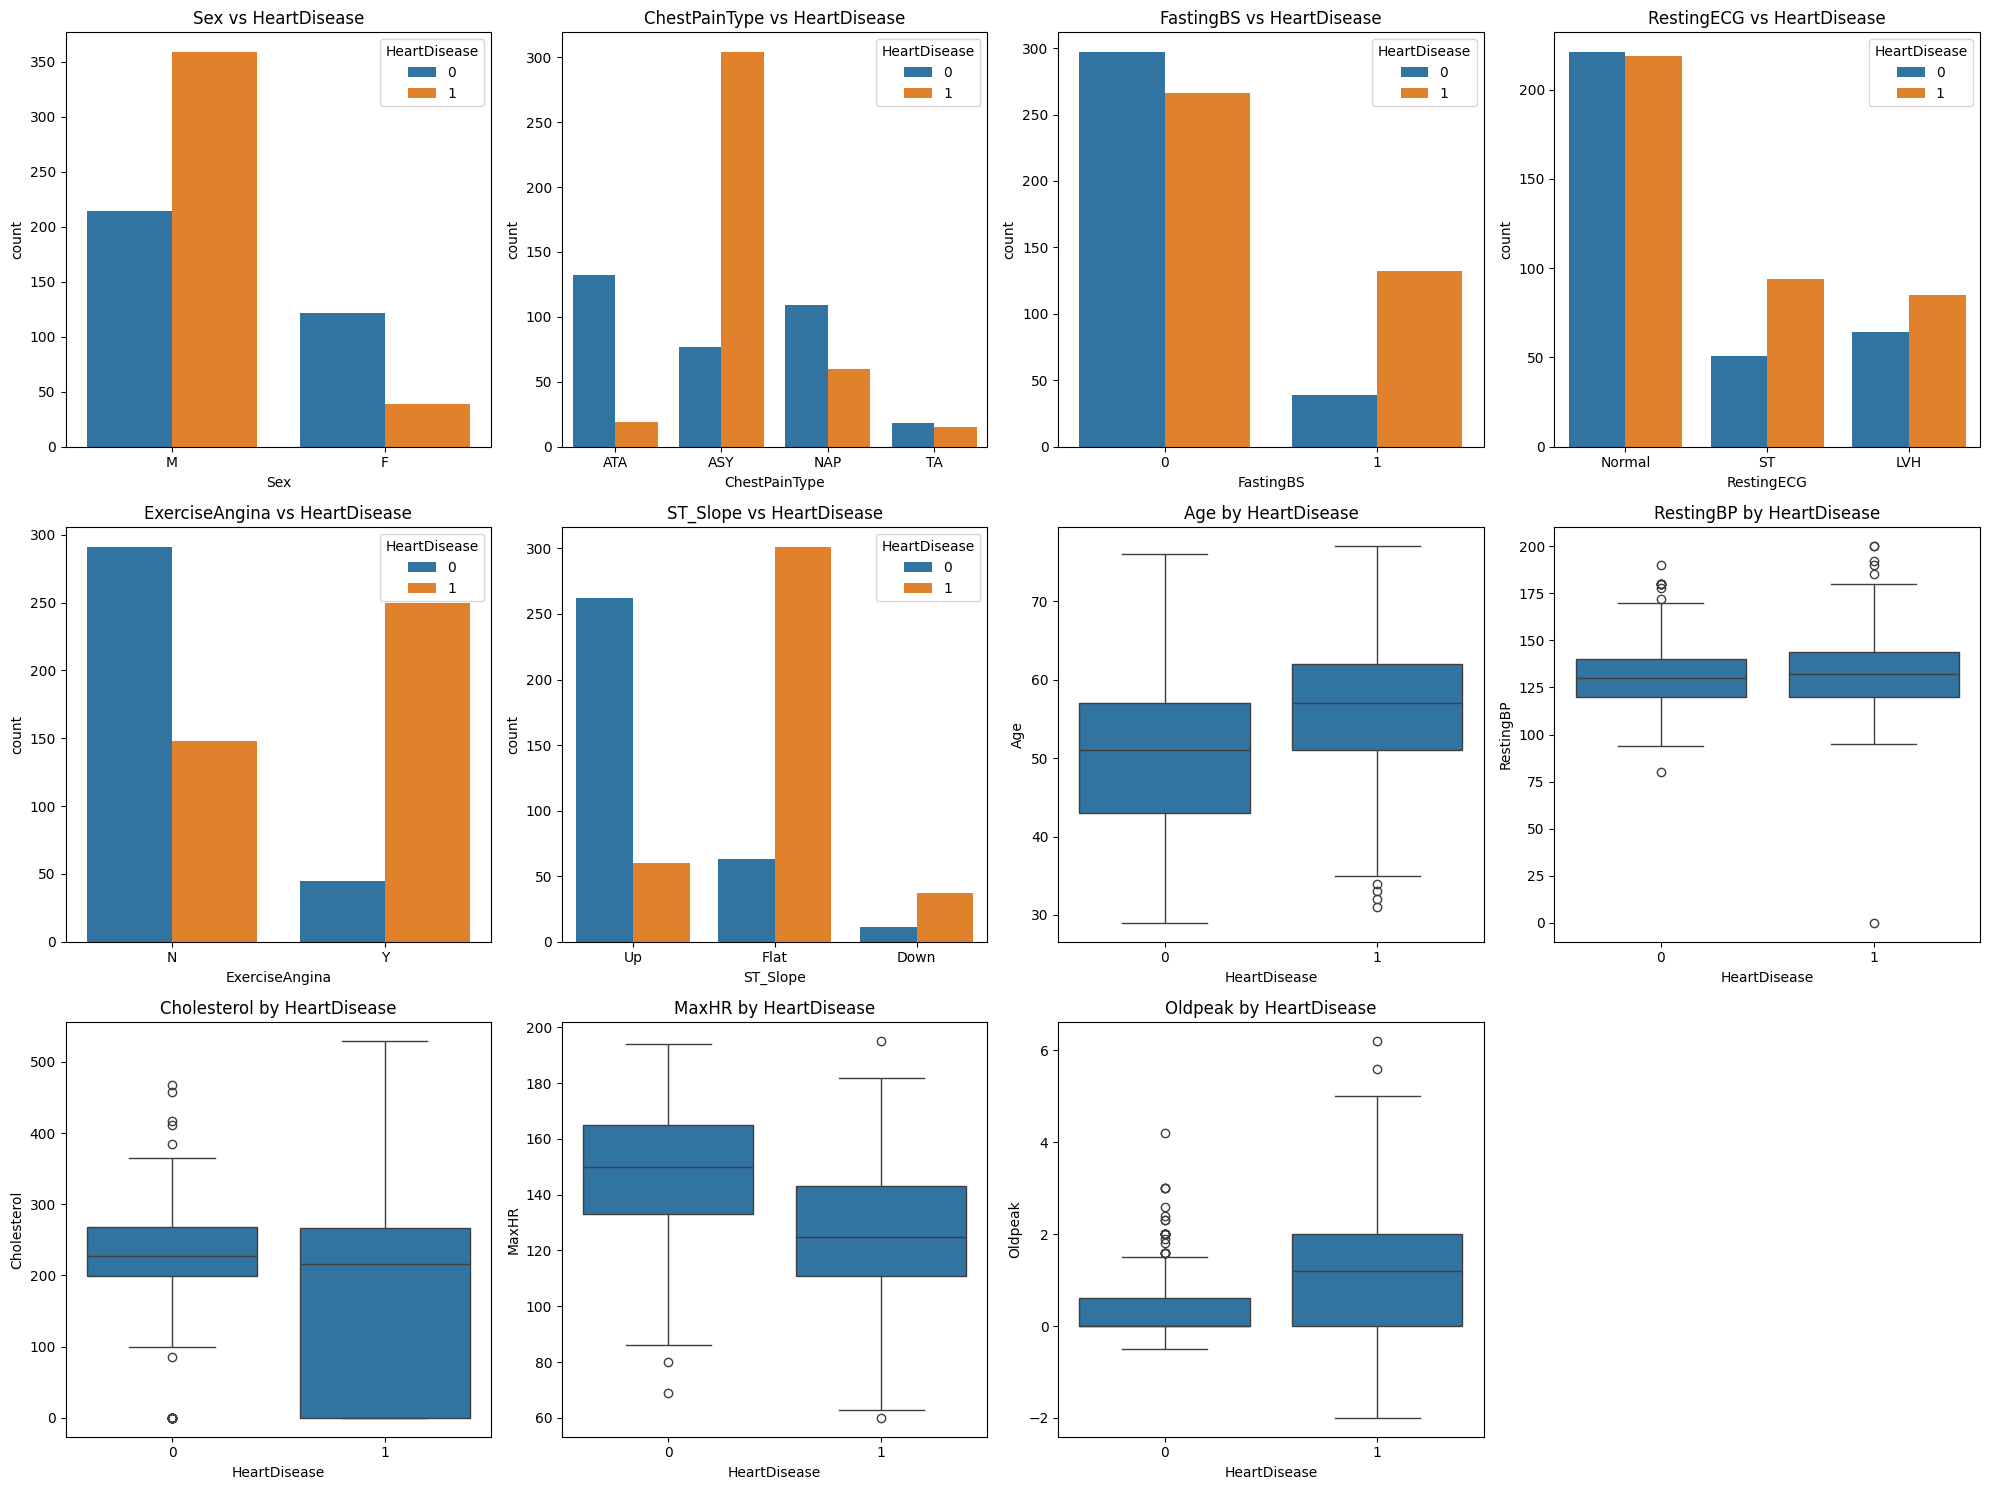

In [347]:
# 2 - features' relationship with heart disease
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
# categorical features
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for i, feature in enumerate(categorical_features, start=0):
    sb.countplot(data=df, x=feature, hue='HeartDisease', ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'{feature} vs HeartDisease')
    axes[i // 4, i % 4].legend(title='HeartDisease', loc='upper right')
# numerical features
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for i, feature in enumerate(numerical_features, start=6):
    sb.boxplot(data=df, x='HeartDisease', y=feature, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'{feature} by HeartDisease')
fig.delaxes(axes[2, 3])
plt.tight_layout()
plt.show()

In [348]:
# 3 - numerical results of the above plots
# categorical features
categorical_stats = {}
for feature in categorical_features:
    stats = df.groupby([feature, 'HeartDisease']).size().unstack(fill_value=0)
    categorical_stats[feature] = stats
# numerical features
numerical_stats = {}
for feature in numerical_features:
    stats = df.groupby('HeartDisease')[feature].describe()
    numerical_stats[feature] = stats

# display
print("Categorical Features:")
for feature, stats in categorical_stats.items():
    print(f"\n{feature} vs HeartDisease")
    display(stats)
print("\nNumerical Features:")
for feature, stats in numerical_stats.items():
    print(f"\n{feature} by HeartDisease")
    display(stats)

Categorical Features:

Sex vs HeartDisease


HeartDisease,0,1
Sex,,
F,122,39
M,214,359



ChestPainType vs HeartDisease


HeartDisease,0,1
ChestPainType,,
ASY,77,304
ATA,132,19
NAP,109,60
TA,18,15



FastingBS vs HeartDisease


HeartDisease,0,1
FastingBS,,
0,297,266
1,39,132



RestingECG vs HeartDisease


HeartDisease,0,1
RestingECG,,
LVH,64,85
Normal,221,219
ST,51,94



ExerciseAngina vs HeartDisease


HeartDisease,0,1
ExerciseAngina,,
N,291,148
Y,45,250



ST_Slope vs HeartDisease


HeartDisease,0,1
ST_Slope,,
Down,11,37
Flat,63,301
Up,262,60



Numerical Features:

Age by HeartDisease


,count,mean,std,min,25%,50%,75%,max
HeartDisease,,,,,,,,
0,336.0,50.502976,9.331698,29.0,43.0,51.0,57.0,76.0
1,398.0,56.072864,8.726878,31.0,51.0,57.0,62.0,77.0



RestingBP by HeartDisease


,count,mean,std,min,25%,50%,75%,max
HeartDisease,,,,,,,,
0,336.0,130.008929,16.587621,80.0,120.0,130.0,140.0,190.0
1,398.0,133.796482,20.031745,0.0,120.0,132.0,144.0,200.0



Cholesterol by HeartDisease


,count,mean,std,min,25%,50%,75%,max
HeartDisease,,,,,,,,
0,336.0,227.639881,72.721990,0.0,198.75,228.0,268.0,468.0
1,398.0,172.218593,126.712372,0.0,0.00,216.0,267.0,529.0



MaxHR by HeartDisease


,count,mean,std,min,25%,50%,75%,max
HeartDisease,,,,,,,,
0,336.0,147.342262,22.998224,69.0,133.0,150.0,165.0,194.0
1,398.0,126.733668,23.320231,60.0,111.0,125.0,143.0,195.0



Oldpeak by HeartDisease


,count,mean,std,min,25%,50%,75%,max
HeartDisease,,,,,,,,
0,336.0,0.378571,0.673520,-0.5,0.0,0.0,0.6,4.2
1,398.0,1.292211,1.181774,-2.0,0.0,1.2,2.0,6.2


### 1.3 - correlation analysis

Age               0.294751
Sex               0.319183
ChestPainType    -0.390924
RestingBP         0.101420
Cholesterol      -0.253538
FastingBS         0.254086
RestingECG        0.048260
MaxHR            -0.405552
ExerciseAngina    0.502205
Oldpeak           0.420891
ST_Slope         -0.568581
Name: HeartDisease, dtype: float64

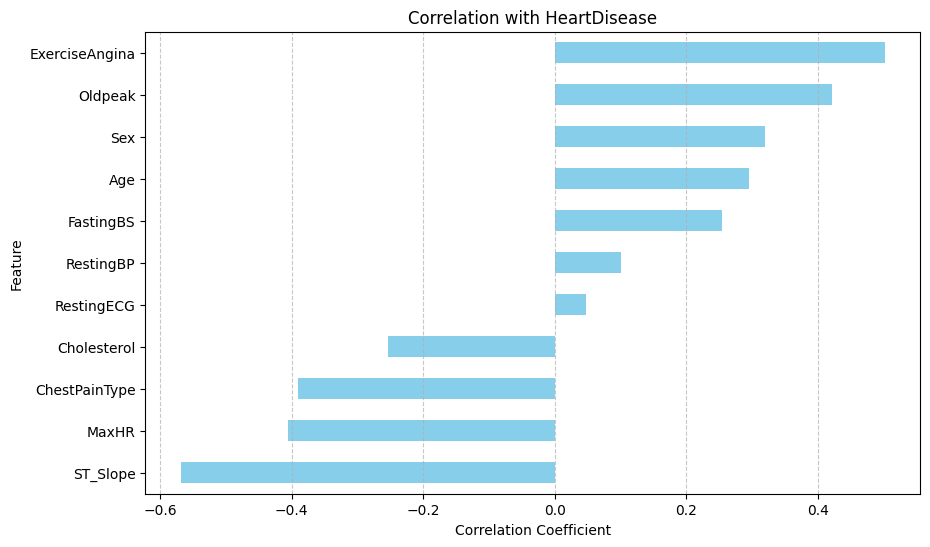

In [349]:
# 4 - encode non-numerical categorical features to integers
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['ChestPainType'] = label_encoder.fit_transform(df['ChestPainType'])
df['FastingBS'] = label_encoder.fit_transform(df['FastingBS'])
df['RestingECG'] = label_encoder.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = label_encoder.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])
# 5 - correlation coefficient analysis
# numerical version
correlation = df.corr()['HeartDisease'].drop('HeartDisease')
display(correlation)
# plot version
plt.figure(figsize=(10, 6))
correlation.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation with HeartDisease')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### NOTES AND OBSERVATIONS
#### sanity check:
- correlation coefficient close to 1 (either positive or negative) indicates a strong linear relationship between the two variables
- correlation coefficient close to 0 suggests little to no linear relationship between the two variables
- positive correlation coefficient indicates that as the feature increases, the target variable tends to increase as well
- negative correlation coefficient indicates that as the feature increases, the target variable tends to decrease
-------------------------------------------------------------------------------------------------------------------------------------
#### features correlation coefficient analysis:
- AGE = moderate positive correlation with 'HeartDisease' (0.29)
- SEX = moderate positive correlation with 'HeartDisease' (0.32)
- CHEST PAIN TYPE = moderate negative correlation with 'HeartDisease' (-0.39)
- RESTING BP = weak positive correlation with 'HeartDisease' (0.10)
- CHOLESTEROL = weak negative correlation with 'HeartDisease' (-0.25)
- FASTING BS = weak positive correlation with 'HeartDisease' (0.25)
- RESTING ECG = very weak positive correlation with 'HeartDisease' (0.05)
- MAX HR = moderate negative correlation with 'HeartDisease' (-0.41)
- EXERCISE ANGINA = strong positive correlation with 'HeartDisease' (0.50)
- OLD PEAK = moderate positive correlation with 'HeartDisease' (0.42)
- ST SLOPE = strong negative correlation with 'HeartDisease' (-0.57)
-------------------------------------------------------------------------------------------------------------------------------------
#### most related features:
- ExerciseAngina
- ST_Slope
- Oldpeak
- Sex
- Cholesterol
-------------------------------------------------------------------------------------------------------------------------------------
#### less related features:
- RestingECG
- RestingBP
- Age
- FastingBS
- MaxHR

### DOUBTS
- theory says that downwards ST slope should be correlated with CHD -> instead from our data flat appears to be correlated --> why?
- sex is really a good feature or is the experiment biased?
- as matteo pointed out some features have values 0 which do not make sense -> we should exclude those

### 1.4 - pitfalls

In [350]:
# some features have 0 values which not make sense, sex is imbalanced?, what else?

### 1.5 - data preprocessing

In [351]:
# TODO

## 2 - Q2 Lasso regression

#### 2.1 - data preprocessing (?)

In [352]:
# 1 - data
df_train = pd.read_csv("datasets/heart_failure/train_val_split.csv")
df_test = pd.read_csv("datasets/heart_failure/test_split.csv")
# 2 - sketch of preprocessing (try also without)
#df_train = df_train[df_train['Cholesterol'] > 0]
#df_test = df_test[df_test['Cholesterol'] > 0]
#df_train = df_train[df_train['Oldpeak'] > 0]
#df_test = df_test[df_test['Oldpeak'] > 0]
# 3 - encode categorical data
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
label_encoder = LabelEncoder()
df_train[categorical_features] = df_train[categorical_features].apply(label_encoder.fit_transform)
df_test[categorical_features] = df_test[categorical_features].apply(label_encoder.fit_transform)

df_train["Cholesterol"].replace(0, np.nan, inplace=True)
df_test["Cholesterol"].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
df_train = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns.values)
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns.values )


# 4 - normalization
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
feat_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('all', feat_transformer, numerical_features + categorical_features)
    ]
)
train_preprocessed_raw = preprocessor.fit_transform(df_train)
test_preprocessed_raw = preprocessor.transform(df_test)
# 5 - back into df shape
processed_columns = numerical_features + categorical_features
train_preprocessed = pd.DataFrame(train_preprocessed_raw, columns=processed_columns)
test_preprocessed = pd.DataFrame(test_preprocessed_raw, columns=processed_columns)
# 6 - split X,y

X_train = train_preprocessed.drop(columns=['HeartDisease'])
y_train = train_preprocessed['HeartDisease']
X_test = test_preprocessed.drop(columns=['HeartDisease'])
y_test = test_preprocessed['HeartDisease']




/tmp/ipykernel_10534/3572211756.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["Cholesterol"].replace(0, np.nan, inplace=True)
/tmp/ipykernel_10534/3572211756.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

### 2.2 - lasso regression

In [353]:
# 1 - fit
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
print('best alpha = ', best_alpha)

lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

train_score = lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)

print("train R^2 Score:", train_score)
print("test R^2 Score:", test_score)

best alpha =  0.00017107930120499802
train R^2 Score: 0.5241778898603702
test R^2 Score: 0.41268866528496906


### 2.3 - feature coefficients

In [354]:
# coeff
coefficients = lasso.coef_
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
#sort by impirtance
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
print(coefficients_df)

           Feature  Coefficient
10        ST_Slope    -0.246970
5              Sex     0.207248
6    ChestPainType    -0.182180
9   ExerciseAngina     0.179985
7        FastingBS     0.157866
4          Oldpeak     0.077136
3            MaxHR    -0.061875
0              Age     0.047803
2      Cholesterol     0.031882
1        RestingBP    -0.009312
8       RestingECG    -0.002203


#### NOTES AND OBSERVATIONS:
- I noticed that if I discard Oldpeak<0 -> train and test have similar values
- big difference with >0 or not

## 3 - Q3 MLP + SHAP

### 3.1 - data preprocessing (same as before BUT no changes to HD)

In [355]:
# 1 - data
df_train = pd.read_csv("datasets/heart_failure/train_val_split.csv")
df_test = pd.read_csv("datasets/heart_failure/test_split.csv")
# 2 - sketch of preprocessing (try also without)
df_train = df_train[df_train['Cholesterol'] > 0]
df_test = df_test[df_test['Cholesterol'] > 0]
df_train = df_train[df_train['Oldpeak'] > 0]
df_test = df_test[df_test['Oldpeak'] > 0]
# 3 - encode categorical data
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoder = LabelEncoder()
for col in categorical_features:
    df_train[col]=label_encoder.fit_transform(df_train[col])
    df_test[col]=label_encoder.transform(df_test[col])
# 4 - normalization
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
feat_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('all', feat_transformer, numerical_features + categorical_features)
    ]
)
train_preprocessed_raw = preprocessor.fit_transform(df_train)
test_preprocessed_raw = preprocessor.fit_transform(df_test)
# 5 - back into df shape
processed_columns = numerical_features + categorical_features
train_preprocessed = pd.DataFrame(train_preprocessed_raw, columns=processed_columns)
test_preprocessed = pd.DataFrame(test_preprocessed_raw, columns=processed_columns)
# 6 - split X,y
X_train = train_preprocessed
y_train = df_train['HeartDisease'].reset_index(drop=True)
X_test = test_preprocessed
y_test = df_test['HeartDisease'].reset_index(drop=True)
print(X_test)

         Age  RestingBP  Cholesterol     MaxHR   Oldpeak       Sex  \
0   0.561753   0.531702     0.420215  0.146358  1.561072  0.444444   
1   0.789269   0.827092    -0.089128  0.685473 -0.116092 -2.250000   
2   0.447995   1.654185    -1.000584 -2.189809 -0.595282  0.444444   
3   0.447995  -0.708936    -1.215044 -0.976799 -0.595282  0.444444   
4   0.675511   0.590780    -0.129339  0.415916  1.800667  0.444444   
..       ...        ...          ...       ...       ...       ...   
92  0.675511   0.354468    -0.678894 -1.740546  0.003705  0.444444   
93 -0.348310  -0.472624    -0.625279  0.775326 -0.595282  0.444444   
94 -2.282196  -0.945248    -0.705701 -0.392758  0.123503  0.444444   
95  0.220479   0.236312    -0.786124  0.415916 -1.314067  0.444444   
96 -0.120795   0.236312    -0.156147  0.955031 -0.355687  0.444444   

    ChestPainType  FastingBS  RestingECG  ExerciseAngina  ST_Slope  
0       -0.664769  -0.427699   -1.492251        0.873863 -0.188646  
1       -0.664769  -0

### 3.2 - MLP

In [356]:
mlp = MLPClassifier(activation='relu',hidden_layer_sizes=(11,),solver='adam',max_iter=300,random_state=25)
mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))

0.8762886597938144


/home/ilboglions/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### 3.3 - SHAP

#### SHAP split by class

In [357]:
# 1 - SHAP values
# make model callable
def predict_proba(X):
    return mlp.predict_proba(X)
explainer = shap.Explainer(predict_proba, X_train)
shap_values = explainer(X_test)

In [358]:
# 2 - pick 2 positive and 2 negative samples
positive_samples_index = np.array(y_test[y_test == 1].index[:2])
negative_samples_index = np.array(y_test[y_test == 0].index[:2])

##### positive samples plots

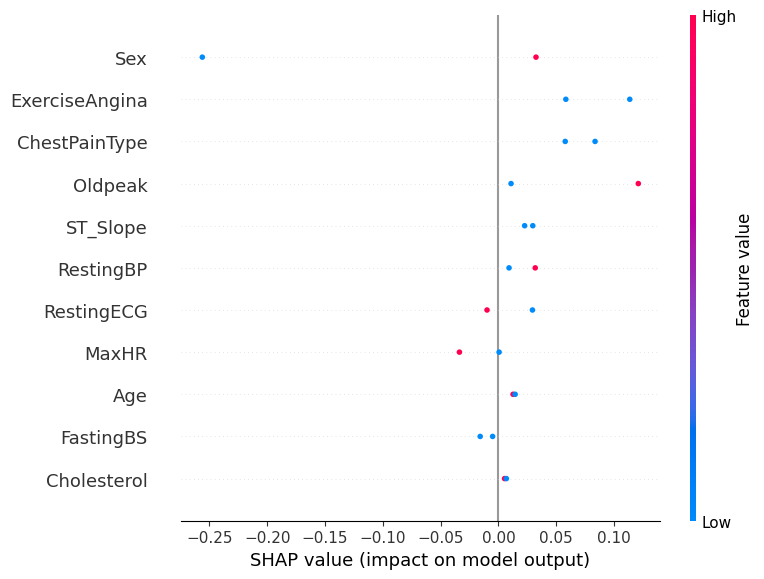

In [359]:
shap.summary_plot(shap_values[:,:,1][positive_samples_index],X_test.iloc[positive_samples_index],feature_names=X_train.columns.values)

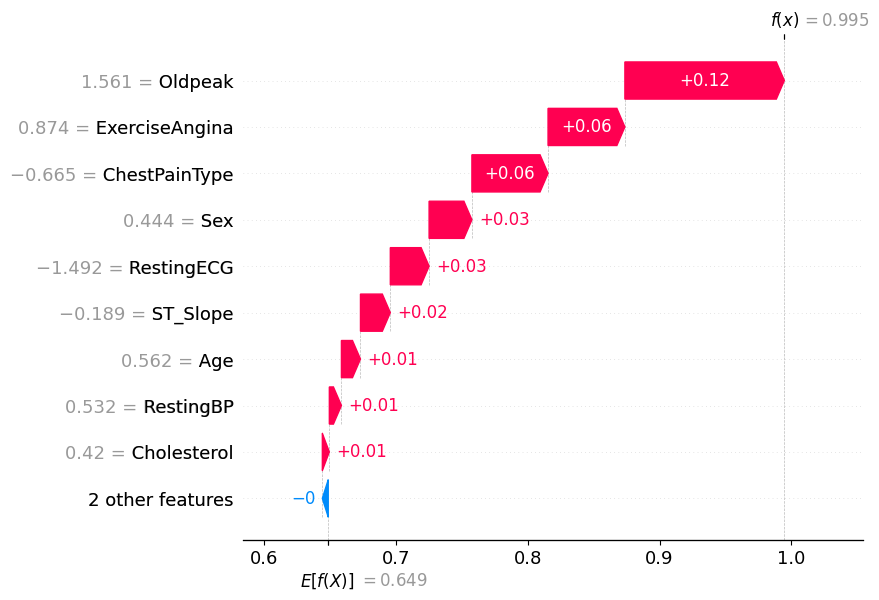

In [360]:
shap.plots.waterfall(shap_values[:,:,1][positive_samples_index[0]], max_display=10)

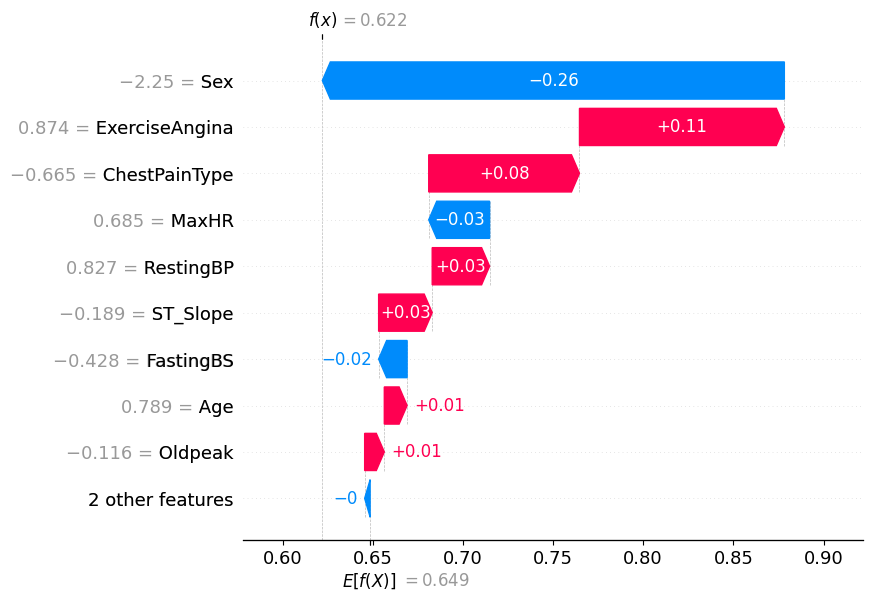

In [361]:
shap.plots.waterfall(shap_values[:,:,1][positive_samples_index[1]], max_display=10)

##### negative samples plots

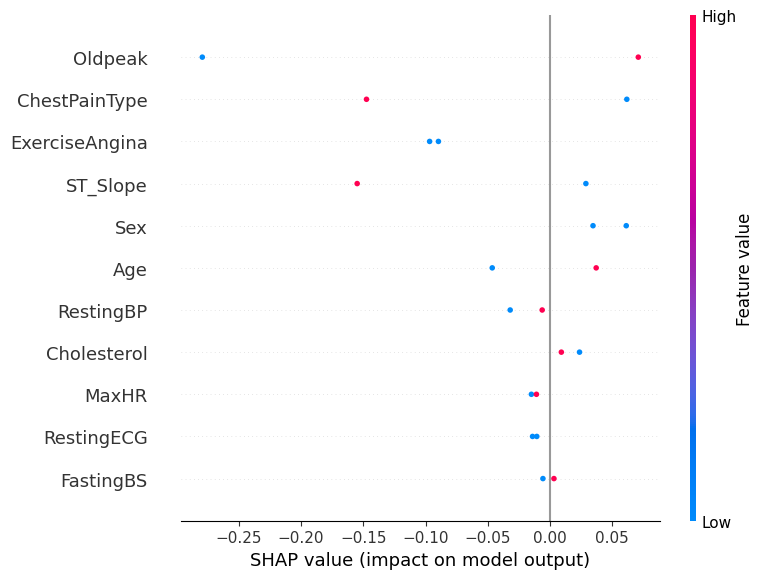

In [362]:
shap.summary_plot(shap_values[:,:,1][negative_samples_index],X_test.iloc[negative_samples_index],feature_names=X_train.columns.values)

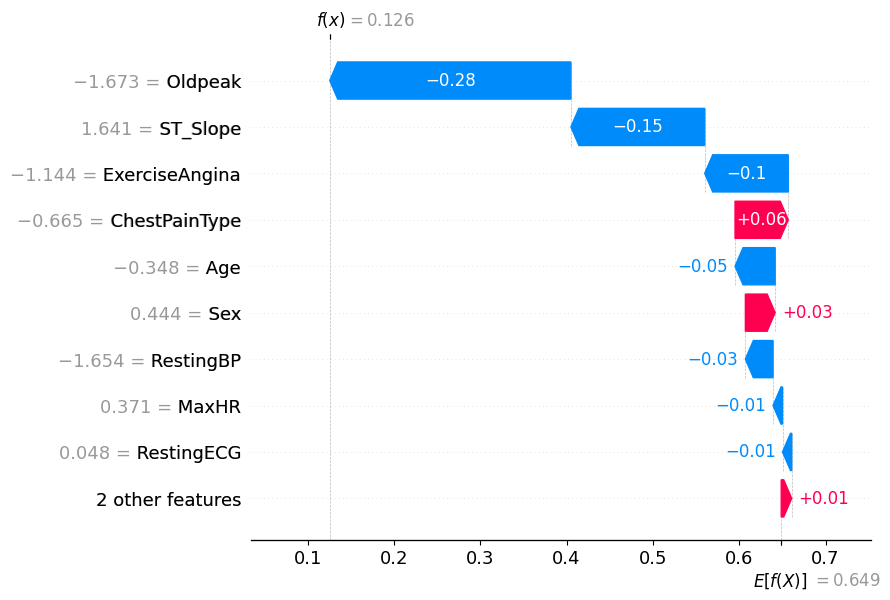

In [363]:
shap.plots.waterfall(shap_values[:,:,1][negative_samples_index[0]], max_display=10)

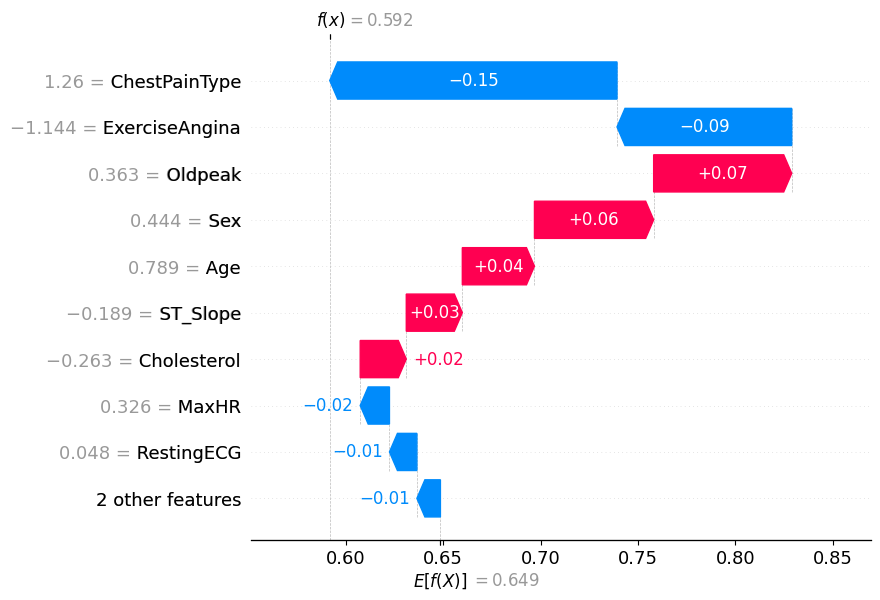

In [364]:
shap.plots.waterfall(shap_values[:,:,1][negative_samples_index[1]], max_display=10)

#### SHAP on all data

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/97 [00:00<?, ?it/s]

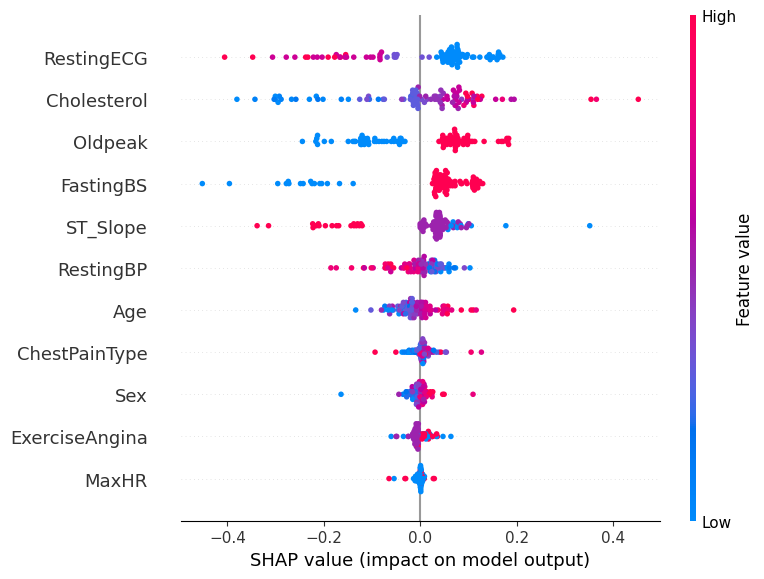

In [365]:
# 1 - SHAP values
explainer = shap.KernelExplainer(mlp.predict, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values,X_test,feature_names=df_train.columns.values)